# Import lib

In [27]:
from pyMSOO.MFEA.model import MFEA_base, SM_MFEA, LSA21
from pyMSOO.utils.Crossover import *
from pyMSOO.utils.Mutation import *
from pyMSOO.utils.Selection import *
from pyMSOO.utils.Search import * 
from pyMSOO.MFEA.benchmark.continous import *
from pyMSOO.utils.MultiRun.RunMultiTime import * 

from pyMSOO.utils.EA import * 
from pyMSOO.MFEA.benchmark.continous.CEC17 import CEC17_benchmark 
from pyMSOO.MFEA.benchmark.continous.WCCI22 import WCCI22_benchmark
from pyMSOO.MFEA.benchmark.continous.funcs import * 

from pyMSOO.utils.MultiRun.RunMultiTime import * 
from pyMSOO.utils.MultiRun.RunMultiBenchmark import * 

from pyMSOO.utils.LoadSaveModel.load_utils import loadModel, loadModelFromTxt
from pyMSOO.utils.LoadSaveModel.save_utils import export_history2txt

from pyMSOO.utils.numba_utils import *

# Run

## Define Tasks

In [2]:
# t, ic = CEC17_benchmark.get_10tasks_benchmark()

# ls_benchmark = [t]
# ls_IndClass = [ic]
# name_benchmark = ["cec17"]

# ls_benchmark = []
# ls_IndClass = []
# ls_tasks = [1]
# name_benchmark = [] 

# for i in ls_tasks:
#     # t, ic = WCCI22_benchmark.get_complex_benchmark(i)
#     t, ic = WCCI22_benchmark.get_50tasks_benchmark(i)
#     ls_benchmark.append(t)
#     ls_IndClass.append(ic)
#     name_benchmark.append(str(i))

ls_benchmark = []
ls_IndClass = []
ls_tasks = [1]
name_benchmark = [] 

for i in ls_tasks:
    # t, ic = WCCI22_benchmark.get_complex_benchmark(i)
    t, ic = WCCI22_benchmark.get_complex_benchmark(i)
    ls_benchmark.append(t)
    ls_IndClass.append(ic)
    name_benchmark.append(str(i))

## SM-MFEA

In [3]:
smpModel = MultiBenchmark(
    ls_benchmark= ls_benchmark,
    name_benchmark= name_benchmark,
    ls_IndClass= ls_IndClass,
    model= SM_MFEA
)

smpModel.compile( 
    crossover = SBX_Crossover(nc = 2),
    mutation = PolynomialMutation(nm = 5, pm= 1),
    selection= ElitismSelection(random_percent= 0),
    search= L_SHADE(len_mem= 15),
    attr_tasks = ['crossover', 'mutation', 'search'],
)
smpModel.fit(
    nb_generations= 1000, nb_inds_each_task= 100, nb_inds_min= 20,
    lr = 0.1, p_const_intra= 0., prob_search = 0., lc_nums = 200,
    nb_epochs_stop= 1000, swap_po= False,
    evaluate_initial_skillFactor= True
)
a = smpModel.run(
    nb_run= 1,     
    save_path= './RESULTS/'
)

Seed: 0 -- Time: 00m 35.49s  100 % [====================>]  Pop_size: 3.80E+01  ,  Cost: 6.06E+02  6.10E+02  ,  
[0.5 0.5]
[100086, 99920]
END!
DONE!
Saved


### Load Model

In [28]:
model_algorithms = loadModel(
    PATH= "RESULTS/WCCI22_bencmark_6.mso",
    ls_tasks= WCCI22_benchmark.get_50tasks_benchmark(3)[0]
    )

In [4]:
model = loadModelFromTxt(
    source_path= "./RESULTS/MTOSOO_P1.txt",  
    model_algorithm= SM_MFEA, 
    multitime_model_class= MultiTimeModel, 
    target_path= "./RESULTS/", 
    remove_tasks= True, 
    history_cost_shape= (1000, 2), 
    nb_runs= 1,
    ls_tasks= WCCI22_benchmark.get_complex_benchmark(1)[0],

)

In [6]:
model.history_cost[-1]

array([605.513152, 610.187823])

In [ ]:
a = np.random.rand(100, 100)

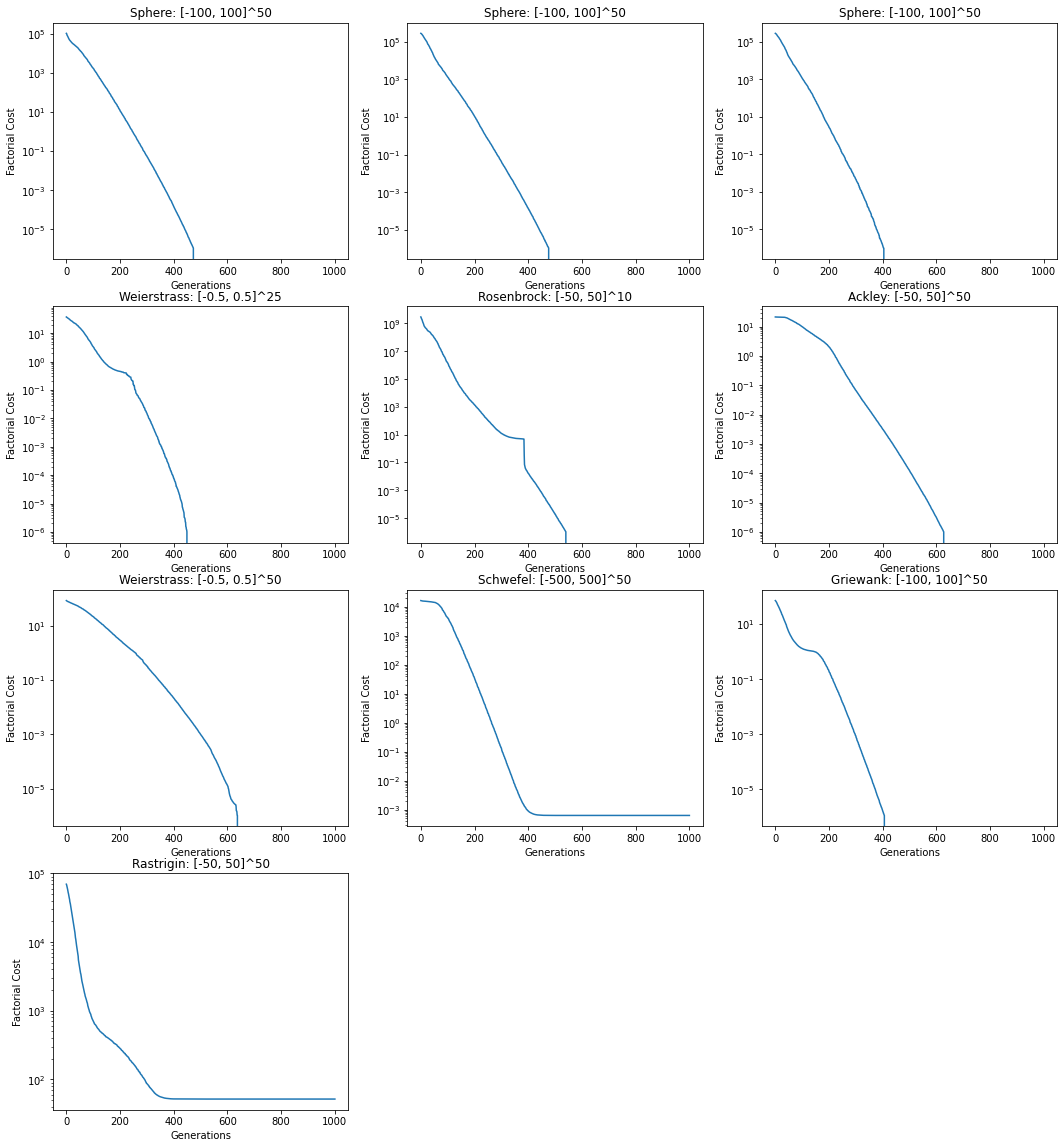

In [ ]:
model_algorithms.render_history(yscale='log')

## Convert

In [2]:
import pickle 
import os 

def export2txt(source_file, 
               save_file, 
               total_evals = int(100000 * 2), 
                steps = 1000, ):
        model = pickle.load(open(source_file, 'rb'))
        tmp = np.concatenate([model['ls_model'][i]['history_cost'] for i in range(len(model['ls_model']))], axis=1)
        stt = np.arange(total_evals // steps, total_evals + total_evals // steps, total_evals // steps)
        # stt = stt.reshape(1,int((200000)/ 2000))
        stt = stt.reshape(1, -1) 
        tmp = tmp.T
        if tmp.shape[1] > stt.shape[1]:
            tmp = tmp[:, -stt.shape[1]:]
        else: 
            print(tmp.shape)
            print(tmp[0:2, 0])
            tmp = np.concatenate([np.repeat(tmp[:, 0:1], stt.shape[1] - tmp.shape[1], axis=1), tmp], axis=1)
            print(tmp.shape)
            print(tmp[0:2, 1])
        assert tmp.shape[1] == stt.shape[1], print(tmp.shape)
        tmp4= np.concatenate([stt, tmp], axis=0).T

        f = open(save_file, "w")
        for line in tmp4: 
            f.write(", ".join([str(int(line[0]))] + [str('{:.6f}'.format(e)) for e in line[1:]]) + "\n")
        f.close()

def export_all2txt(source_folder, destination_folder): 
    for item in os.listdir(source_folder): 
        current_source_path= os.path.join(source_folder, item)
        if os.path.isdir(current_source_path):
            export_all2txt(current_source_path, os.path.join(destination_folder, item))
        else: 
            current_save_path = os.path.join(destination_folder, item)[:-4] + ".txt"
            if os.path.isdir(destination_folder) is False: 
                os.makedirs(destination_folder) 
            print(current_source_path)
            # file = pickle.load(open(current_source_path, 'rb'))
            export2txt(
                 source_file= current_source_path, 
                 save_file= current_save_path, 
                 total_evals= int(1e5 * 50), 
                 steps= 1000, 
            )

def export_all2mso(source_folder, destination_folder): 
    for item in os.listdir(source_folder): 
        current_source_path= os.path.join(source_folder, item)
        if os.path.isdir(current_source_path):
            export_all2mso(current_source_path, os.path.join(destination_folder, item))
        else: 
            current_save_path = os.path.join(destination_folder, item)[:-4] + ".mso"
            if os.path.isdir(destination_folder) is False: 
                os.makedirs(destination_folder) 
            # print(current_source_path)
            # file = pickle.load(open(current_source_path, 'rb'))
            model = loadModelFromTxt(
                source_path= current_source_path, 
                model_algorithm= AbstractModel, 
                multitime_model_class= MultiTimeModel, 
                target_path= "./", 
                history_cost_shape= (1000, 50), 
                nb_runs= 30, 
                ls_tasks= WCCI22_benchmark.get_50tasks_benchmark(1)[0] 
            )
            saveModel(
                model= model, 
                PATH= current_save_path, 
                remove_tasks= True, 
            )


In [2]:
import os 
len(os.listdir("/home/anhdt-minhdt/Data/GECCO/"))

11

In [ ]:
export_all2txt(source_folder= "/home/anhdt-minhdt/Data_dictmso/GECCO", 
               destination_folder= "./RESULTS/GECCO")

In [4]:
export_all2mso(
    source_folder= "./RESULTS/GECCO/", 
    destination_folder= "./RESULTS/GECCO_mso/"
)

In [48]:
st = "5000, 3233685177.335206, 21.254207, 30267.617163, 26.511870, 76.005243, 15780.898998, 3110869825.840165, 21.165202, 26081.012467, 30.428965, 75.654435, 14913.499115, 3046715276.973135, 21.254558, 29224.821214, 28.466695, 74.382823, 14802.592113, 3262145695.956045, 21.259172, 23831.717600, 29.584425, 76.241141, 15347.361935, 4340220049.324294, 21.280659, 29928.793770, 26.235681, 75.241008, 15118.476184, 4158466463.022346, 21.233533, 27893.570405, 26.138809, 75.879354, 14322.598094, 2378507682.951922, 21.238021, 27246.709104, 27.882461, 72.663462, 14342.353182, 4212939679.652127, 21.277576, 27122.228520, 29.275239, 76.307919, 14371.998614, 4332334679.225216, 21.223583, 3268646653.200590, 21.195695, 27674.272702, 25.437706, 73.571507, 13469.551173, 4040358906.100990, 21.251511, 31310.072726, 30.314340, 65.028095, 14986.232564, 3699659902.655124, 21.234564, 32198.075383, 27.688393, 75.673866, 15185.783739, 3033690138.880203, 21.257353, 24922.776580, 27.791548, 76.544145, 14690.262584, 4117356523.163053, 21.309514, 26707.409261, 27.945564, 76.236798, 14739.845060, 3230594755.800063, 21.298127, 28271.291138, 27.001225, 74.450342, 15067.792429, 3969441308.318172, 21.270080, 28579.819208, 31.807554, 74.530729, 15142.062867, 4496594443.551032, 21.253212, 28032.460045, 27.068178, 75.810248, 15267.046647, 3559647632.182570, 21.212607, 4181763964.417141, 21.315878, 30523.320390, 29.064835, 76.823412, 14978.838458, 4524942956.922293, 21.294569, 25189.534179, 32.344673, 76.370940, 15016.447398, 4705617086.061606, 21.299601, 28107.406418, 24.781467, 75.279210, 15014.988413, 2866894090.795000, 21.274821, 30391.863926, 27.309125, 75.606544, 15622.435698, 3481665803.353276, 21.280866, 28215.129415, 25.220760, 76.799076, 15478.295840, 3944496802.445446, 21.244494, 32213.199875, 30.367754, 76.144408, 15200.955599, 4668558645.848586, 21.158126, 26819.767613, 31.559333, 74.913197, 14704.559261, 4234111940.808698, 21.298140, 29489.639607, 30.082810, 73.807044, 14092.832727, 4281121764.588696, 21.208959, 4199853126.738291, 21.268223, 25991.943539, 25.997502, 70.796736, 14939.799148, 3284710947.335869, 21.233840, 28593.433427, 26.989395, 75.260469, 15333.768276, 3813286969.435486, 21.213758, 26184.350357, 30.712885, 74.069447, 15030.226155, 4048274770.083819, 21.234688, 29000.180849, 29.769509, 76.478196, 13099.573738, 3642536171.657684, 21.339292, 26237.272821, 28.564975, 73.938619, 13983.559107, 3704807749.631057, 21.205291, 22812.474828, 26.582216, 76.311473, 14582.488379, 3979163407.003137, 21.283926, 28748.693026, 28.216349, 67.403092, 14583.481724, 4049279535.810472, 21.267006, 29713.165167, 30.916258, 74.654209, 14929.377382, 4215231526.576835, 21.234569, 3232931827.623110, 21.316796, 29586.508697, 26.170053, 74.065506, 14812.638008, 3326829254.888105, 21.269219, 30483.792660, 29.898021, 72.156221, 14145.842835, 4921848028.388072, 21.228372, 32473.910547, 28.118704, 74.641360, 15042.228153, 3375357724.936391, 21.274729, 26143.694569, 27.897426, 75.471871, 14446.506430, 3644845939.576524, 21.270967, 29728.755176, 24.577693, 76.683746, 15422.460698, 3876395975.775329, 21.308671, 31293.004496, 24.252883, 74.180289, 15689.233472, 3233579075.820123, 21.272411, 28138.059758, 30.027245, 71.853908, 14208.038055, 4396138572.066072, 21.187344, 29605.068006, 29.427001, 75.518551, 14868.986706, 4008095370.876235, 21.148557"
print(len(st.split(",")))

251


In [7]:
model = loadModel("RESULTS/GECCO_mso/EME-BI/3.mso", ls_tasks= WCCI22_benchmark.get_50tasks_benchmark(2)[0])

In [8]:
print(model.history_cost[-1])

[ 97.39071773 101.36885133  77.8305716   73.02912203  90.11771267
  93.11477083  84.09763     81.53223    101.87906627  73.15881177
  81.3184241   91.0869599   74.41751193 105.3853295  119.4569932
  84.18691847  85.54085507  80.99721163  76.51477777  77.84764433
  78.292462    84.1259345   90.85656013  72.3026561   71.68353273
  91.41018407  71.6159987   69.50857207  63.04354183  71.1798443
  91.32376507  75.50503387  83.252781    92.3483157   91.52561437
  91.53450007  90.2771817   84.11137307  69.5873063   94.46997497
  88.19248507  86.8321335   70.5229349   80.2076014   96.84599203
  77.41904717  73.04972883  74.97833043  76.5653682   88.27234403]


In [10]:
file = pickle.load(open("/home/anhdt-minhdt/Data_dictmso/GECCO/EME-BI/3.mso", 'rb'))
np.array(file['history_cost'])[-1][0]

97.390717739899

In [26]:
file = pickle.load(open("/home/anhdt-minhdt/Data_dictmso/CEC17/Compare_conver_trend/S-MFEA_KL_CEC17_PYTHON.mso", 'rb'))
np.array(file['ls_model'][0]['history_cost'])[0]

array([8.89029678e+04, 2.96414107e+05, 2.87396204e+05, 3.86623201e+01,
       2.91565438e+09, 2.13677191e+01, 8.21515024e+01, 1.67931516e+04,
       7.41242427e+01, 7.52473002e+04])

In [2]:
tasks, _ = CEC17_benchmark.get_10tasks_benchmark() 

In [20]:

class Weierstrass(AbstractFunc):
    '''
    global optima = 0^d
    '''    
    def __init__(self, dim, shift: list = 0, rotation_matrix: np.ndarray = None, bound: tuple = None):
        # self.global_optimal = np.array([0] * dim)
        # super().__init__(dim, shift, rotation_matrix, bound)
        self.params = {}
        self.params['a'] = 0.5
        self.params['b'] = 3
        self.params['k_max'] = 21

    # @staticmethod
    # @jit(nopython = True)
    # def _func(x, dim, params: dict):
    #     '''
    #     Request: input x is encoded
    #     '''
    #     left = 0
    #     for i in range(dim):
    #         left += np.sum(params['a'] ** np.arange(params['k_max']) * \
    #             np.cos(2*np.pi * params['b'] ** np.arange(params['k_max']) * (x[i]  + 0.5)))
            
    #     right = dim * np.sum(params['a'] ** np.arange(params['k_max']) * \
    #         np.cos(2 * np.pi * params['b'] ** np.arange(params['k_max']) * 0.5)
    #     )
    #     return left - right

    # def __call__(self, x):
    #     x = self.__class__._convert(x)
    #     x = self.__class__.decode(x, self.dim, self.limited_space, self.bound, self.rotation_matrix, self.shift)
    #     return __class__._func(x,self.dim, self.params)


a = Weierstrass(     50,shift= 0,    bound= [-100, 100]),   # 0 

f = open("te.mso", 'wb')
pickle.dump(a, f)
f.close()

In [17]:
from numba import njit
from numba.typed import List

@njit
def foo(x):
    x.append(10)

a = [1, 2, 3]
typed_a = List()
[typed_a.append(x) for x in a]
foo(typed_a)

In [25]:
from numba import njit
from numba.typed import Dict, List 
import numba 

@njit
def foo(x, y):
    new_a = {}
    index = 0 
    for i in x:
        new_a[i]  = (y[index])
        index += 1  
    return new_a 

def ls_primary_to_ls_numba(ls, default_type= None):
    new_ls = List() 
    if default_type is None: 
        [new_ls.append(x) for x in ls]

    else:
        [new_ls.append(default_type(x)) for x in ls]
    
    return new_ls 

    

# a = [1, 2, 3]
a = {'a': 2.0, 'b': 0.3}
print(a.keys())
b = foo(ls_primary_to_ls_numba(a.keys()), ls_primary_to_ls_numba(a.values(), float))

dict_keys(['a', 'b'])


In [20]:
ae= ls_primary_to_ls_numba(a.keys())

In [22]:
print(ae)

None


In [26]:
print(b)

{a: 2.0, b: 0.3}


In [8]:
print(tasks[0])

In [12]:
import pickle 


f = open("te.mso", 'wb')
pickle.dump(tasks[3], f)
f.close()

TypeError: cannot pickle '_nrt_python._MemInfo' object